# Rating Prediction Project

# Probelm Statement

Rating prediction is a well-known recommendation task aiming to predict a user’s rating for those items which were not rated yet by her. Predictions are computed from users’ explicit feedback, i.e. their ratings provided on some items in the past. Another type of feedback are user reviews provided on items which implicitly express users’ opinions on items. Recent studies indicate that opinions inferred from users’ reviews on items are strong predictors of user’s implicit feedback or even ratings and thus, should be utilized in computation. As far as we know, all the recent works on recommendation techniques utilizing opinions inferred from users’ reviews are either focused on the item recommendation task or use only the opinion information, completely leaving users’ ratings out of consideration. The approach proposed in this paper is filling this gap, providing a simple, personalized and scalable rating prediction framework utilizing both ratings provided by users and opinions inferred from their reviews.

Experimental results provided on dataset containing user ratings and reviews from the real-world Amazon and Flipkart Product Review Data show the effectiveness of the proposed framework.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing nltk libraries
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
import re
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score, confusion_matrix, accuracy_score,classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
lemmatizer = nltk.stem.WordNetLemmatizer()

# Data Collection And Pre-processing

In [3]:
data=pd.read_csv('flipkart.csv')

In [4]:
data.head()

,Unnamed: 0,Review_title,Reiew_text,Ratings
0,0,Value-for-money,"According to my experience under the 25k,\nDis...",4
1,1,Really Nice,"Actually, I felt like this infinix brand is no...",4
2,2,Highly recommended,Best laptop i ever had this is my first laptop...,5
3,3,Wonderful,Laptop is nice but after sometimes heating sta...,4
4,4,Worth every penny,Had been using for the last three days\n\nThe ...,5


In [5]:
# Checking shape of the dataset.
data.shape

(35363, 4)

There are total 35363 rows and 4 columns in our dataset.

In [8]:
# We will drop the irrelevent columns form dataset.
data.drop('Unnamed: 0',axis=1, inplace=True)

In [9]:
# Checking the column info.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35363 entries, 0 to 35362
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_title  35363 non-null  object
 1   Reiew_text    35363 non-null  object
 2   Ratings       35363 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 828.9+ KB


In [10]:
# Checking the total columns in the data.
data.columns

Index(['Review_title', 'Reiew_text', 'Ratings'], dtype='object')

In [11]:
# Checking the null values in dataset.
data.isnull().sum()

Review_title    0
Reiew_text      0
Ratings         0
dtype: int64

<AxesSubplot:>

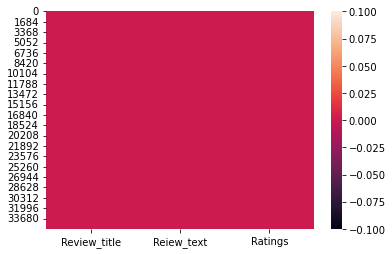

In [13]:
# Checking the null values using heatmap.
sns.heatmap(data.isnull())

Here we can see the dataset doesn't contain any null values.

In [14]:
# Checking the unique values in the dataset.
data.nunique()

Review_title      241
Reiew_text      10626
Ratings             5
dtype: int64

In [15]:
data['Ratings'].unique()

array([4, 5, 3, 1, 2], dtype=int64)

In [16]:
# Joining Review text and title.

data['Review'] = data['Review_title'].map(str)+' '+data['Reiew_text']

In [17]:
# Cheking the columns after combining.
data.head(3)

,Review_title,Reiew_text,Ratings,Review
0,Value-for-money,"According to my experience under the 25k,\nDis...",4,Value-for-money According to my experience und...
1,Really Nice,"Actually, I felt like this infinix brand is no...",4,"Really Nice Actually, I felt like this infinix..."
2,Highly recommended,Best laptop i ever had this is my first laptop...,5,Highly recommended Best laptop i ever had this...


Visualizing text in first three rows from Review column

In [18]:
data['Review'][0]

'Value-for-money According to my experience under the 25k,\nDisplay 10 out of 9 perfect for office work,\nColour accuracy 10 on 10 love it,\nKeyboard keys 10 out of 7 back led keys pretty good for night work,\nTouch pad 10 out of 9 smooth,\nPerformance 10 out of 7 little bit lag if pc upgrade in background,\nSound quality 10 out of 8 enough for single room,\nCamera 10 out of 5 average light useless,\nBattery 10 out of 8 depends on uses,\nWindows 11 performance 10 out of 9,\nStorage speed 10 out of 8,\nStorage capacity 1...\nREAD MORE'

In [19]:
data['Review'][1]

'Really Nice Actually, I felt like this infinix brand is not much popular . But guys believe it satisfies you 100% . You get free trail of 1 month ms office . Only con is getting heat instantly\nYou feel very hot while using laptop apart from that this is an wonderful laptop .'

In [20]:
data['Review'][2]

'Highly recommended Best laptop i ever had this is my first laptop and it is best and cool you buy only from this seller very fast delivery 4 days only delhivery open box delhivery available best laptop value for money it comes with an 45 watt charger you have to charge before use'

In [21]:
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

In [22]:
# Lowercasing
data['Review'] = data['Review'].apply(lambda x : x.lower())

data['Review'] = data['Review'].apply(lambda x : decontracted(x))

#removing punctuations
data['Review'] = data['Review'].str.replace('[^\w\s]','')
data['Review'] = data['Review'].str.replace('\n',' ')


In [23]:
data['Review'][0]

'valueformoney according to my experience under the 25k display 10 out of 9 perfect for office work colour accuracy 10 on 10 love it keyboard keys 10 out of 7 back led keys pretty good for night work touch pad 10 out of 9 smooth performance 10 out of 7 little bit lag if pc upgrade in background sound quality 10 out of 8 enough for single room camera 10 out of 5 average light useless battery 10 out of 8 depends on uses windows 11 performance 10 out of 9 storage speed 10 out of 8 storage capacity 1 read more'

In [24]:
# Remove stopwords
stop = stopwords.words('english')
data['Review'] = data['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [25]:
data['Review'][0]

'valueformoney according experience 25k display 10 9 perfect office work colour accuracy 10 10 love keyboard keys 10 7 back led keys pretty good night work touch pad 10 9 smooth performance 10 7 little bit lag pc upgrade background sound quality 10 8 enough single room camera 10 5 average light useless battery 10 8 depends uses windows 11 performance 10 9 storage speed 10 8 storage capacity 1 read'

In [26]:
# Defining functiom to convert nltk tag to wordnet tags.
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [27]:
# Defining function to lemmatize our text
def lemmatize_sentence(sentence):
    #tokenize the sentence & find the pos tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)

In [32]:
import nltk
nltk.download('averaged_perceptron_tagger')
  
data['Review'] = data['Review'].apply(lambda x : lemmatize_sentence(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\91749\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [34]:
data['Review'][0]

'valueformoney accord experience 25k display 10 9 perfect office work colour accuracy 10 10 love keyboard key 10 7 back lead key pretty good night work touch pad 10 9 smooth performance 10 7 little bit lag pc upgrade background sound quality 10 8 enough single room camera 10 5 average light useless battery 10 8 depends use window 11 performance 10 9 storage speed 10 8 storage capacity 1 read'

In [35]:
data['Review'][1]

'really nice actually felt like infinix brand much popular guy believe satisfy 100 get free trail 1 month m office con get heat instantly feel hot use laptop apart wonderful laptop'

In [36]:
# Noice removal
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.*?>)", "", text)
    #remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    #remove white space
    text = text.strip()
    return text

In [37]:
data['Review'] = data['Review'].apply(lambda x : scrub_words(x))

In [38]:
data['Review'][0]

'valueformoney accord experience k display   perfect office work colour accuracy   love keyboard key   back lead key pretty good night work touch pad   smooth performance   little bit lag pc upgrade background sound quality   enough single room camera   average light useless battery   depends use window  performance   storage speed   storage capacity  read'

In [39]:
data['Review'][1]

'really nice actually felt like infinix brand much popular guy believe satisfy  get free trail  month m office con get heat instantly feel hot use laptop apart wonderful laptop'

Here all html markups, digits and white spaces from the text are removed.And We can understand it by looking at first two row's text from review column

# Exploratory Data Analysis

In [40]:
# Creating column for word counts in the text
data['Review_WC'] = data['Review'].apply(lambda x: len(str(x).split(' ')))
data[['Review_WC','Review']].head()

,Review_WC,Review
0,71,valueformoney accord experience k display pe...
1,31,really nice actually felt like infinix brand m...
2,30,highly recommended best laptop ever first lapt...
3,28,wonderful laptop nice sometimes heat startedpe...
4,60,worth every penny use last three day build qua...


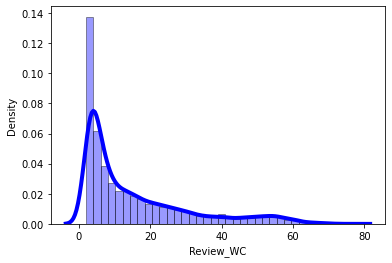

In [47]:
# Density plot and histogram of all word count.
sns.distplot(data['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'blue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [42]:
# Creating column for character counts in the text
data['Review_CC'] = data['Review'].str.len()
data[['Review_CC','Review']].head()

,Review_CC,Review
0,357,valueformoney accord experience k display pe...
1,175,really nice actually felt like infinix brand m...
2,181,highly recommended best laptop ever first lapt...
3,202,wonderful laptop nice sometimes heat startedpe...
4,327,worth every penny use last three day build qua...


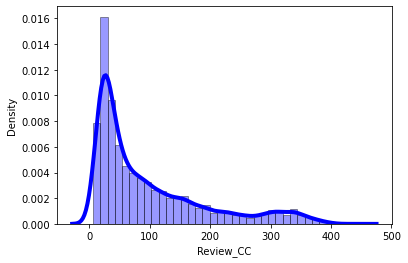

In [48]:
# Density plot and histogram of all character count
sns.distplot(data['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'blue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [49]:
# Checking the Correlation.
data.corr()

,Ratings,Review_WC,Review_CC
Ratings,1.00000,-0.012080,-0.006770
Review_WC,-0.01208,1.000000,0.991865
Review_CC,-0.00677,0.991865,1.000000


<AxesSubplot:>

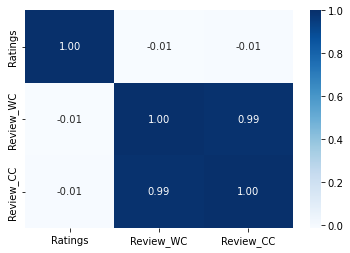

In [54]:
# Visualizing correlation using heatmap.
sns.heatmap(data.corr(),cmap='Blues',fmt='0.2f',annot=True)

In [55]:
# Checking the skewness in dataset.
data.skew()

Ratings     -1.768697
Review_WC    1.457246
Review_CC    1.374466
dtype: float64

# Checking Outliers

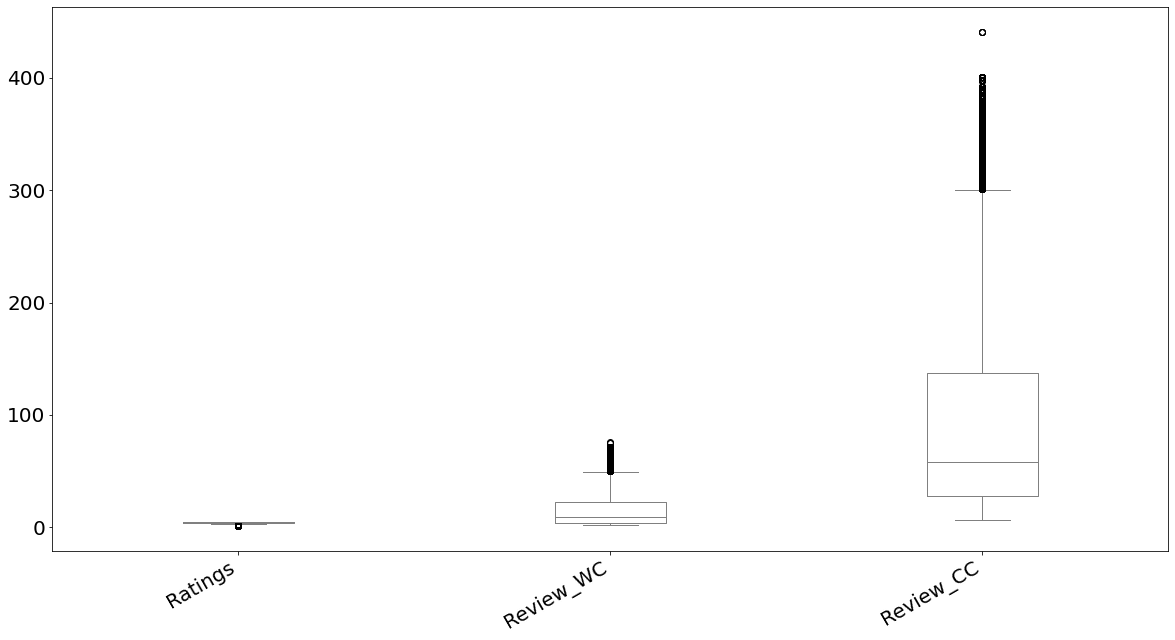

In [44]:
# Checking the outliers in the dataset.
data.plot(kind='box',fontsize=20,figsize=(20,10),color='grey')
plt.xticks(rotation=30,ha='right')
plt.show()

Here we can see the outliers in Review_CC column and some in Review_WC.

In [56]:
# apply zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(data[['Review_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
data = data[filtering_entry]
data.shape

(35106, 6)

In [57]:
# Data loss after outlier removal.
Data_loss=((35363-35106)/35363)*100
Data_loss

0.7267482962418347

Here we only loss 7% data that is acceptable.

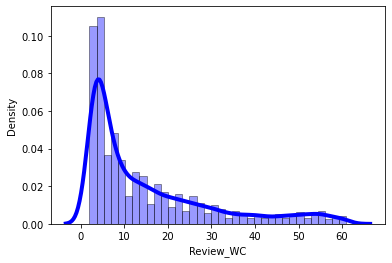

In [59]:
# Density plot and histogram of all word count
sns.distplot(data['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'blue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

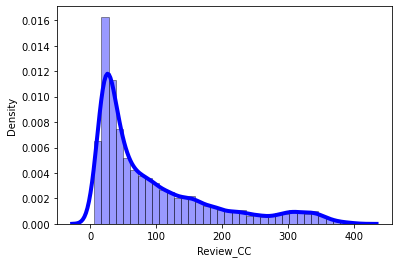

In [60]:
#density plot and histogram of all word count
sns.distplot(data['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'blue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [61]:
data

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
1,Really Nice,"Actually, I felt like this infinix brand is no...",4,really nice actually felt like infinix brand m...,31,175
2,Highly recommended,Best laptop i ever had this is my first laptop...,5,highly recommended best laptop ever first lapt...,30,181
3,Wonderful,Laptop is nice but after sometimes heating sta...,4,wonderful laptop nice sometimes heat startedpe...,28,202
4,Worth every penny,Had been using for the last three days\n\nThe ...,5,worth every penny use last three day build qua...,60,327
5,Great product,"brilliant design, so sleek and beautiful. stil...",5,great product brilliant design sleek beautiful...,32,194
...,...,...,...,...,...,...
35358,Decent product,Back bown not comfortable but chair 🪑 was very...,3,decent product back bown comfortable chair good,7,47
35359,More suitable for tall people,'Am writing the review after using the chair f...,4,suitable tall people write review use chair al...,23,140
35360,Utterly Disappointed,Product and Flipkart services both are terribl...,1,utterly disappointed product flipkart service ...,8,71
35361,Nice product,This product is good quality. Worth for money....,4,nice product product good quality worth money ...,21,133


5    22298
4     6994
1     2994
3     2075
2      745
Name: Ratings, dtype: int64


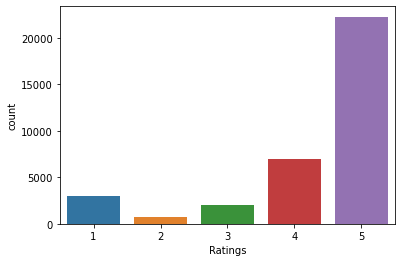

In [62]:
#Check the count of target column
sns.countplot(data['Ratings'])
print(data.Ratings.value_counts())
plt.show()

Looking at the above count plot for our target varible(Ratings) we can say that the data set is having most number of reviews rated as 5 star. and very less number of reviews rated as 2.
Which will cause the Imbalance problem for our model.
So I am selecting equal number of reviews of each rating as a input for our model
For that first I will shuffle the dataset so that we can select data from both web-sites
Then I will select equal number of data of every category

In [63]:
#shuffling the data set
data = data.sample(frac=1).reset_index(drop=True)

In [64]:
data

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,Brilliant,"As of now, looks decent... Vil share actual wo...",5,brilliant look decent vil share actual work co...,10,63
1,Mind-blowing purchase,Excellent to have this watch..just got little ...,5,mindblowing purchase excellent watchjust get l...,13,94
2,Very Good,"Nice phone, camera is superb battery backup is...",4,good nice phone camera superb battery backup n...,16,105
3,Just okay,Camera problem,3,okay camera problem,3,19
4,Awesome,"Best laptop I ever had. Great performance, gre...",5,awesome best laptop ever great performance gre...,19,123
...,...,...,...,...,...,...
35101,Simply awesome,Good looking and good watch I'm very happy I b...,5,simply awesome good look good watch happy buy ...,13,80
35102,Brilliant,Pros:\n1. Good battery life\n2. Great connecti...,5,brilliant pro good battery life great connec...,60,342
35103,Very Good,quality,4,good quality,2,12
35104,Value-for-money,The 50 MP camera performs like a 48 MP camera ...,4,valueformoney mp camera performs like mp cam...,19,113


In [68]:
#selct data from every category
df1 = data[data['Ratings']==1][0:745]
df2 = data[data['Ratings']==2][0:745]
df3 = data[data['Ratings']==3][0:745]
df4 = data[data['Ratings']==4][0:745]
df5 = data[data['Ratings']==5][0:745]

In [69]:
#Combining all the dataframes into one and shuffling them 
data = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
data

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,Good choice,good product\nperformance is fastest,4,good choice good product performance fast,6,41
1,Utterly Disappointed,AI voice assistant not working\nCall function ...,1,utterly disappointed ai voice assistant work c...,10,72
2,Absolute rubbish!,Poor product. Video works. Audio does not work...,1,absolute rubbish poor product video work audio...,15,89
3,Hated it!,Not a good phone don't waste your money....,1,hat good phone waste money,5,26
4,Mind-blowing purchase,Value for money,5,mindblowing purchase value money,4,32
...,...,...,...,...,...,...
3720,Highly recommended,Watch quality is really awesome and also color...,5,highly recommended watch quality really awesom...,27,198
3721,Really Nice,Very nice experience,4,really nice nice experience,4,27
3722,Bad quality,Out look is very beautiful but the bearing sec...,2,bad quality look beautiful bearing section poo...,16,105
3723,Good choice,I am writing the review after 40 days of usage...,4,good choice write review day usage good buil...,54,333


4    745
1    745
5    745
3    745
2    745
Name: Ratings, dtype: int64


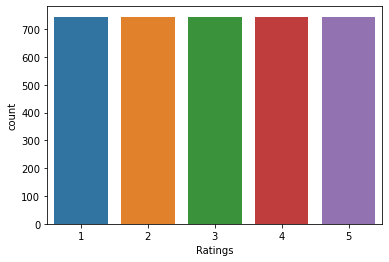

In [70]:
#lets Check the count of target column again
sns.countplot(data['Ratings'])
print(data.Ratings.value_counts())
plt.show()

In [71]:
#function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_data = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_data.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

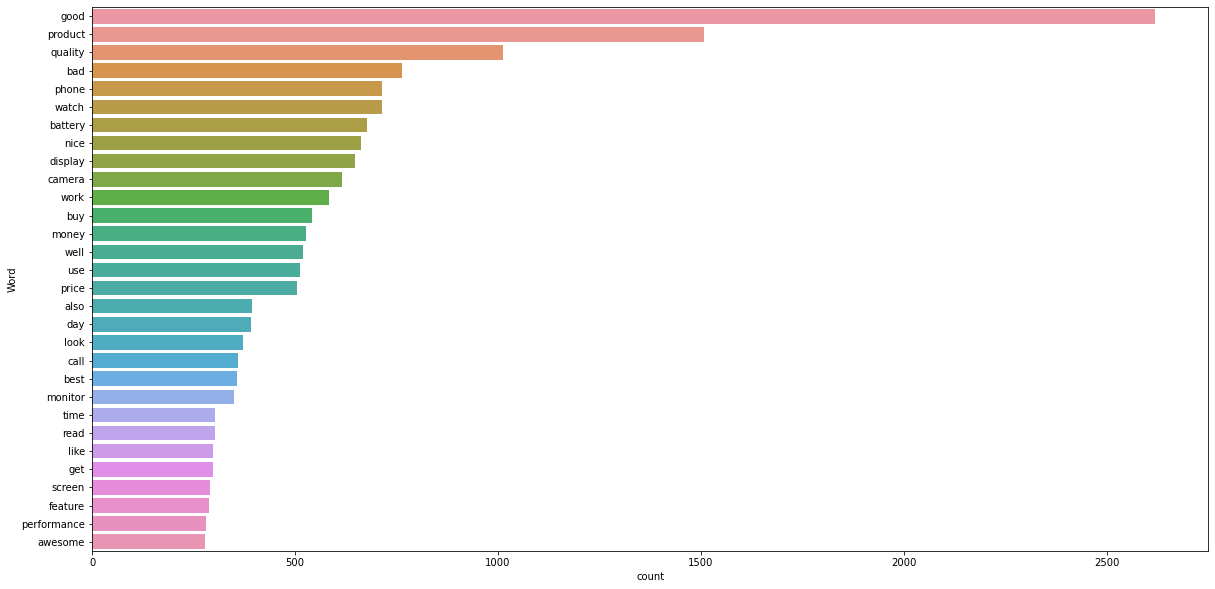

In [72]:
freq_words(data['Review'])

In [73]:
#function to plot least frequent terms
def rare_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_data = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_data.nsmallest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

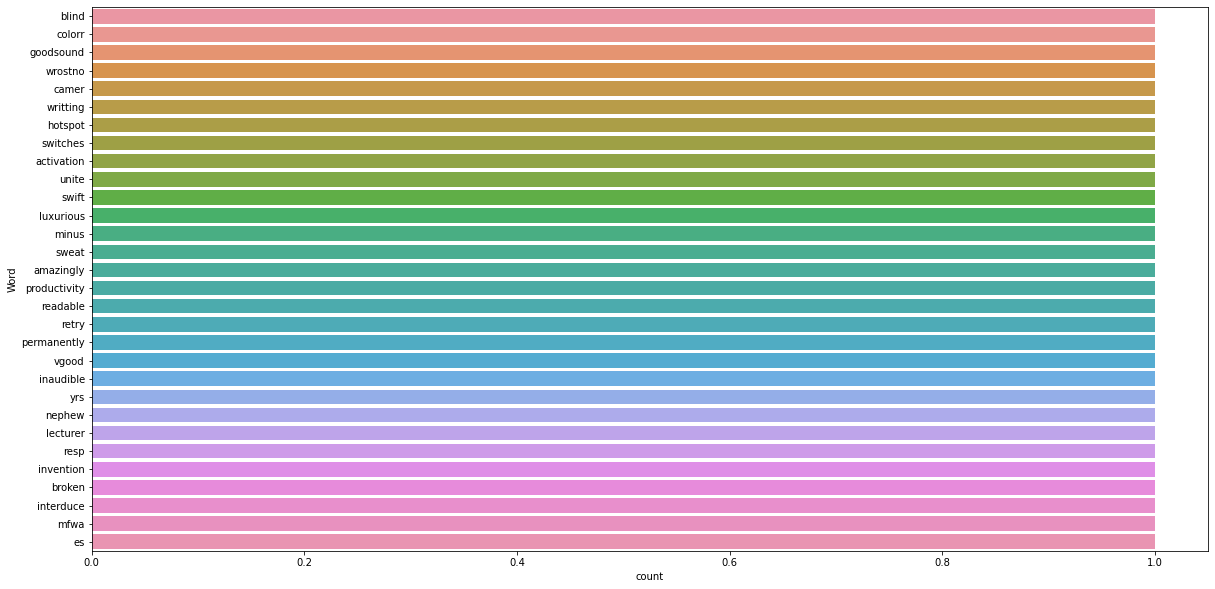

In [74]:
rare_words(data['Review'])

Word Cloud

In [75]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stopwords,
                    max_words = 500,
                    max_font_size = 40,
                    scale = 3,
                    random_state = 1).generate(str(data))
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

Word For Rating=1

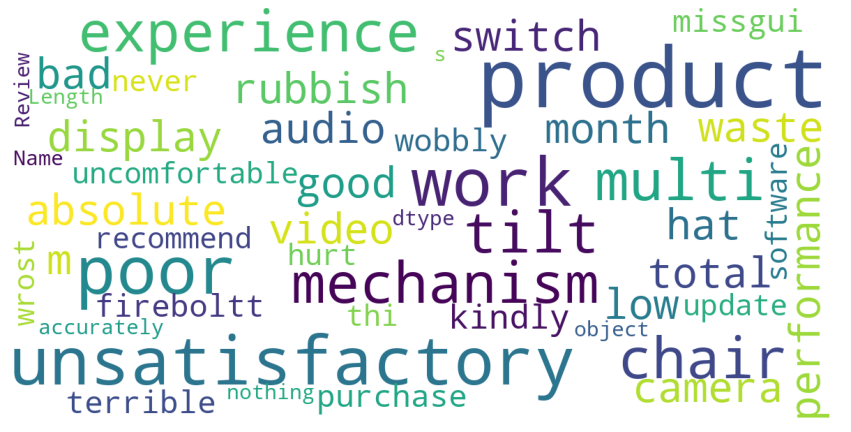

In [76]:
show_wordcloud(df1['Review'])

Word for Rating =2

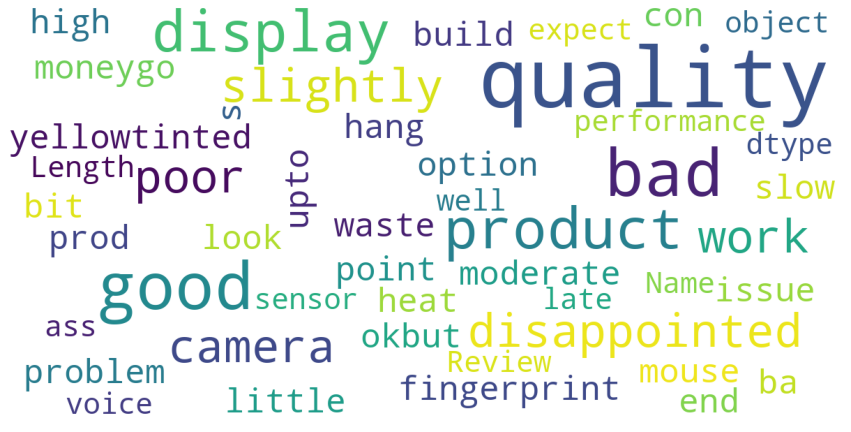

In [77]:
show_wordcloud(df2['Review'])

Words for Ratings=3

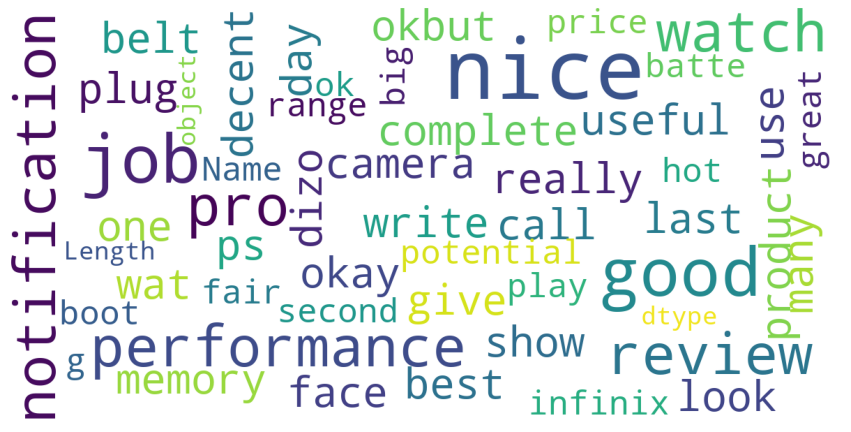

In [78]:
show_wordcloud(df3['Review'])

Words for Ratings =4

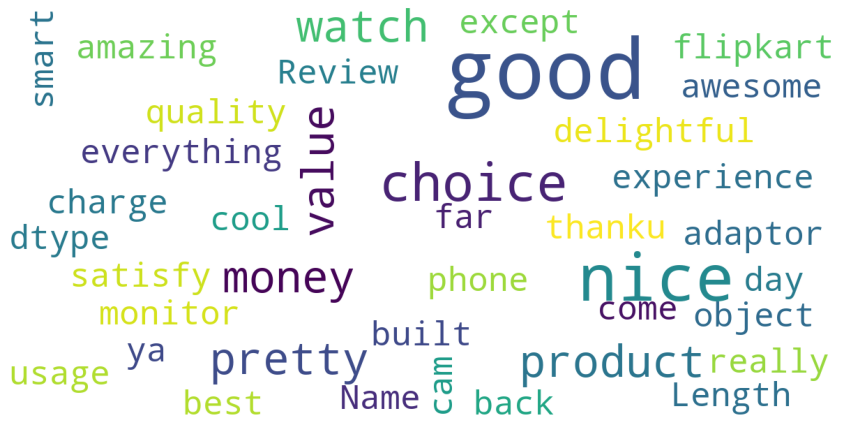

In [79]:
show_wordcloud(df4['Review'])

Words for Ratings=5

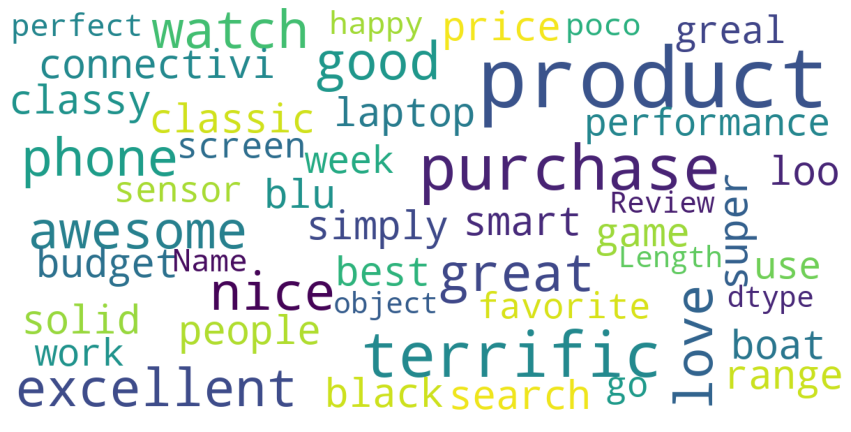

In [80]:
show_wordcloud(df5['Review'])

# Model Building and Evaluation

In [81]:
# Separating features and labels
x = data['Review']
y = data['Ratings']

# Converting text into vectors using TfidfVectorizer

In [82]:
#using the n_gram tfidf vectorizer(Word vectors)
word_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                stop_words = 'english',
                                ngram_range = (1,3),
                                max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [86]:
#Character vectors
char_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'char',
                                stop_words = 'english',
                                ngram_range = (2,6),
                                max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

In [84]:
#I will combine both word vectors and character vectors as input for our model
train_features = hstack([train_char_features,train_word_features])

In [85]:
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.25, random_state = 1)

In [87]:
#lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (2793, 100432)
x_test (932, 100432)
y_train (2793,)
y_test (932,)


In [88]:
#defining the algorithms
rf = RandomForestClassifier()
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
bnb = BernoulliNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()

In [96]:
#creating a function to train and test the model with evaluation
def BuiltModel(model):
    print('-'*30+model.__class__.__name__+'-'*30)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    accuracy = accuracy_score(y_test,pred)*100

    print(f"Accuracy Score:", accuracy)

    #confusion matrix & classification report
    
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred)}\n")
    

In [97]:
for model in [lr,svc,bnb,mnb,sgd,rf]:
    BuiltModel(model)

------------------------------LogisticRegression------------------------------
Accuracy Score: 91.41630901287554
CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.94      0.97      0.95       183
           2       0.98      0.95      0.96       183
           3       0.87      0.90      0.88       187
           4       0.85      0.86      0.86       190
           5       0.94      0.90      0.92       189

    accuracy                           0.91       932
   macro avg       0.92      0.91      0.91       932
weighted avg       0.92      0.91      0.91       932

Confusion Matrix : 
 [[177   1   3   1   1]
 [  3 173   2   5   0]
 [  4   3 168  10   2]
 [  1   0  17 164   8]
 [  3   0   4  12 170]]

------------------------------LinearSVC------------------------------
Accuracy Score: 90.98712446351931
CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.92      0.97      0.94      

In [98]:
def cross_val(model):
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score :", scores)

In [99]:
for model in [lr,svc,sgd,rf,mnb,bnb]:
    cross_val(model)

Cross validation score : 91.67805299606442
Cross validation score : 92.08062948559743
Cross validation score : 91.78532022078016
Cross validation score : 91.6511280576025
Cross validation score : 86.95312638544488
Cross validation score : 77.87823266866582


In [100]:
#lets selects different parameters for tuning
grid_params = {
                'penalty':['l2'],
                'loss':['hinge','squared_hinge'],
                'multi_class': ['ovr'],
                'intercept_scaling':[2,3],
                'dual':[True,False],
                }

In [101]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(svc, grid_params, cv = 3, verbose=10)
GCV.fit(x_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 1/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2;, score=0.908 total time=   2.3s
[CV 2/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 2/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2;, score=0.930 total time=   2.1s
[CV 3/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 3/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2;, score=0.923 total time=   2.3s
[CV 1/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 1/3; 2/8] END dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2;, score=0.910 total time=   1.9s
[CV 2/3; 2/8] START dual=True, intercept_scaling=2, loss=squared

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'dual': [True, False], 'intercept_scaling': [2, 3],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr'], 'penalty': ['l2']},
             verbose=10)

In [102]:
GCV.best_params_  

{'dual': True,
 'intercept_scaling': 2,
 'loss': 'hinge',
 'multi_class': 'ovr',
 'penalty': 'l2'}

In [103]:
#training and testing our final model with above parameters
model = LinearSVC(dual = True, intercept_scaling = 2, loss = 'hinge', multi_class = 'ovr', penalty = 'l2')
model.fit(x_train,y_train) #fitting data to model
pred = model.predict(x_test)
accuracy = accuracy_score(y_test,pred)*100

#printing accuracy score
print("Accuracy Score :", accuracy)

#printing Confusion matrix
print(f"\nConfusion Matrix : \n {confusion_matrix(y_test,pred)}\n")

#printing Classification report
print(f"\nCLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")

Accuracy Score : 90.87982832618026

Confusion Matrix : 
 [[177   1   4   0   1]
 [  4 172   2   5   0]
 [  7   3 161  13   3]
 [  0   0  14 164  12]
 [  3   0   2  11 173]]


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.93      0.97      0.95       183
           2       0.98      0.94      0.96       183
           3       0.88      0.86      0.87       187
           4       0.85      0.86      0.86       190
           5       0.92      0.92      0.92       189

    accuracy                           0.91       932
   macro avg       0.91      0.91      0.91       932
weighted avg       0.91      0.91      0.91       932



In [104]:
import joblib
joblib.dump(model,"Rating_Prediction.pkl")

['Rating_Prediction.pkl']